In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings 

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
quandl.ApiConfig.api_key = 'StB_9bvPyrWpy6a9_ijm'

In [3]:
data = quandl.get('FRED/B1066G3A086NBEA')

In [4]:
data.head(500)

,Value
Date,
1929-01-01,1.547
1930-01-01,1.449
1931-01-01,1.383
1932-01-01,1.284
1933-01-01,1.218
...,...
2017-01-01,107.255
2018-01-01,109.738
2019-01-01,111.937


In [5]:
data.shape

(93, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

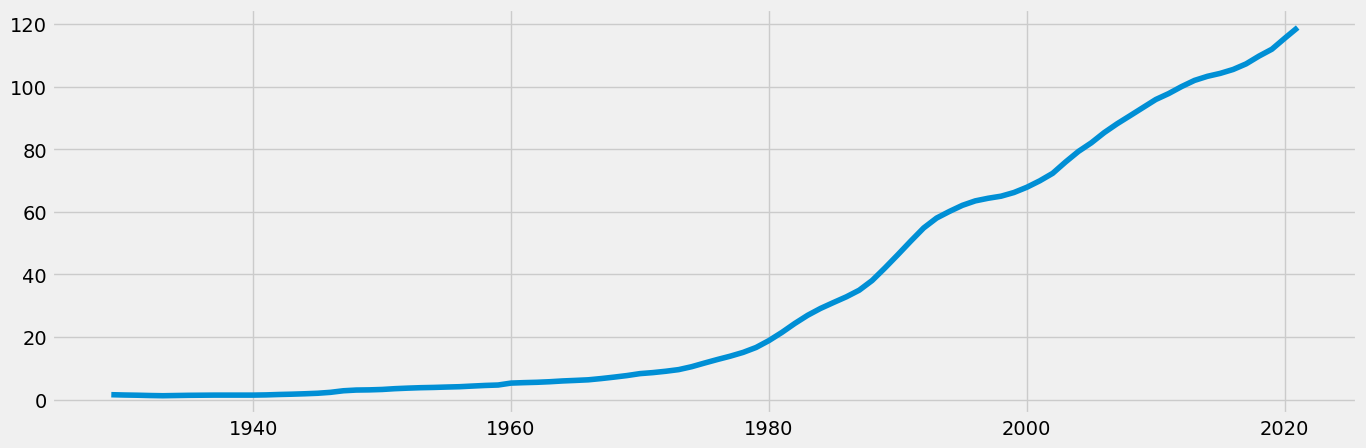

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)


In [9]:
data_2=data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1929-01-01,1.547
1,1930-01-01,1.449
2,1931-01-01,1.383
3,1932-01-01,1.284
4,1933-01-01,1.218


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-12-31')]

In [12]:
data_sub.shape

(41, 2)

In [13]:
data_sub.head()

,Date,Value
51,1980-01-01,18.839
52,1981-01-01,21.438
53,1982-01-01,24.301
54,1983-01-01,26.917
55,1984-01-01,29.115


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,18.839
1981-01-01,21.438
1982-01-01,24.301
1983-01-01,26.917
1984-01-01,29.115


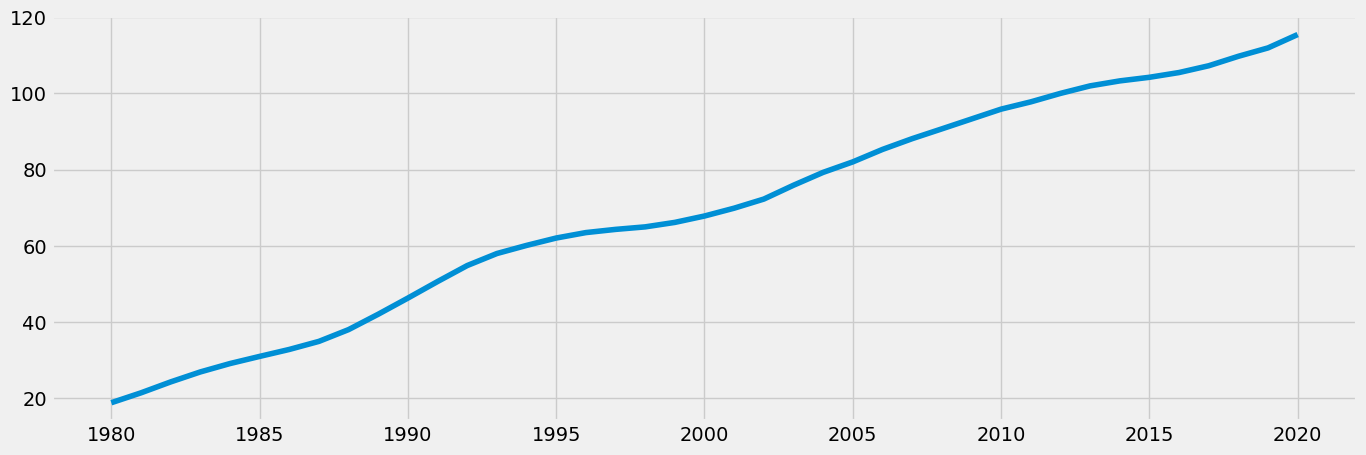

In [15]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
dups = data_sub.duplicated()
dups.sum()

0

# Time Series  Analysis


In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

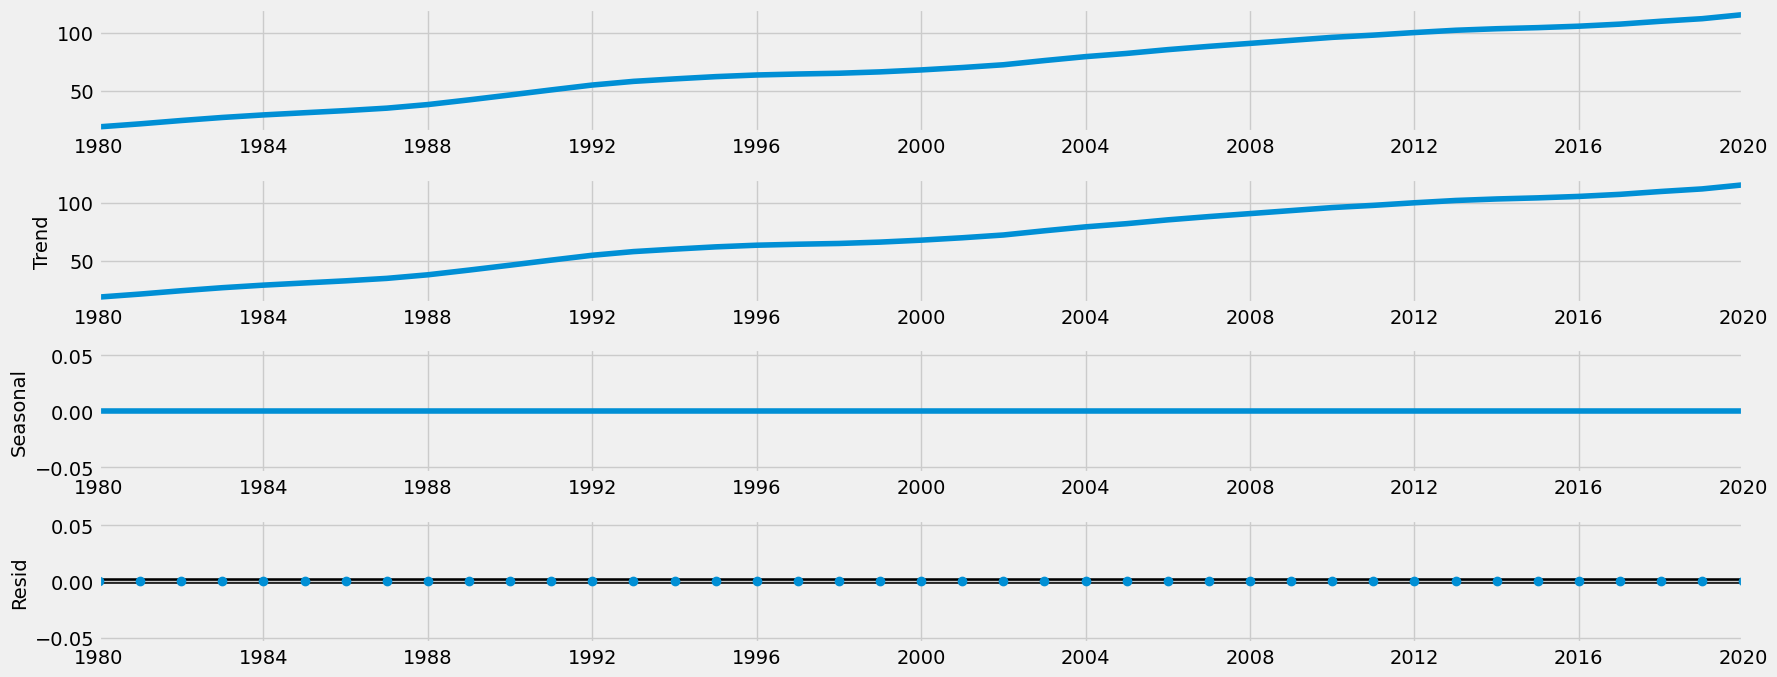

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

# Stationary Testing

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.627482
p-value                         0.468809
Number of Lags Used             5.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


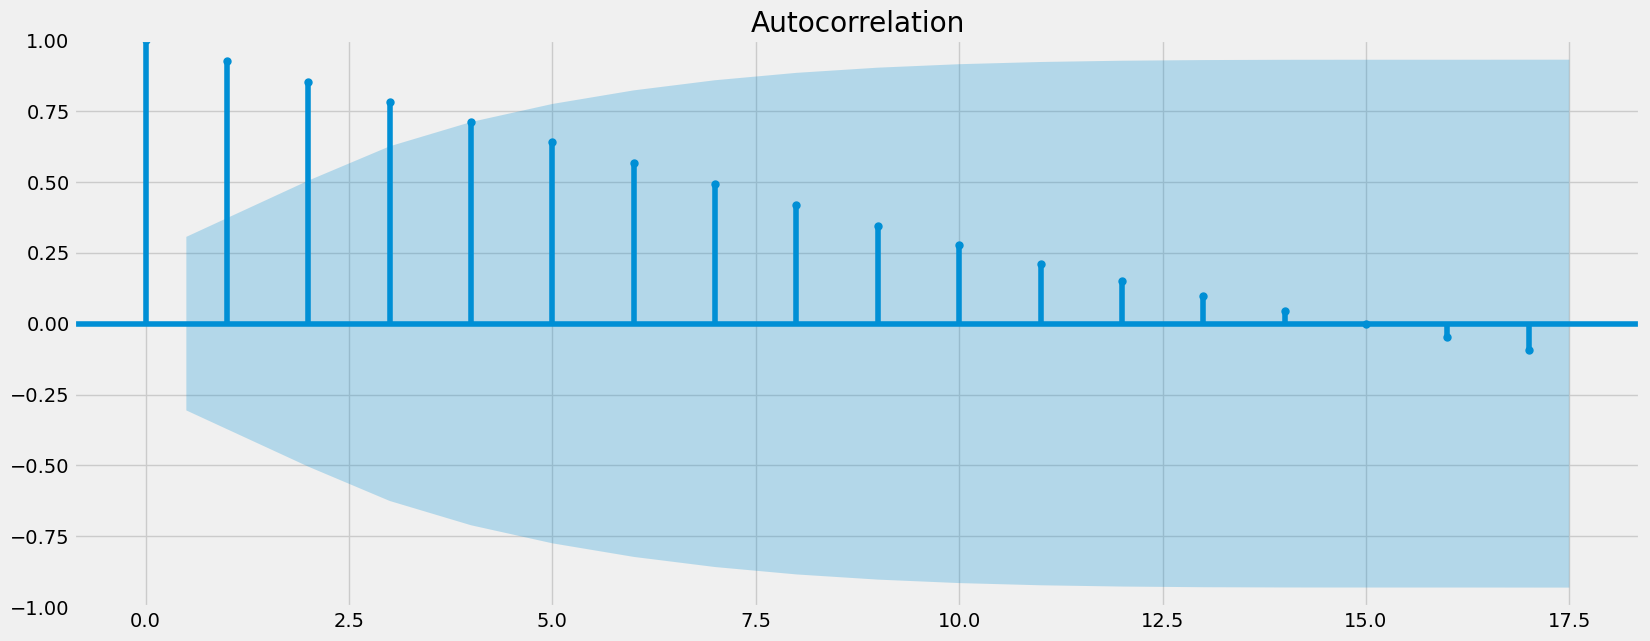

In [22]:
 #Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# Stationarizing Time Series Data 

In [23]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()


,Value
datetime,
1981-01-01,2.599
1982-01-01,2.863
1983-01-01,2.616
1984-01-01,2.198
1985-01-01,1.879


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

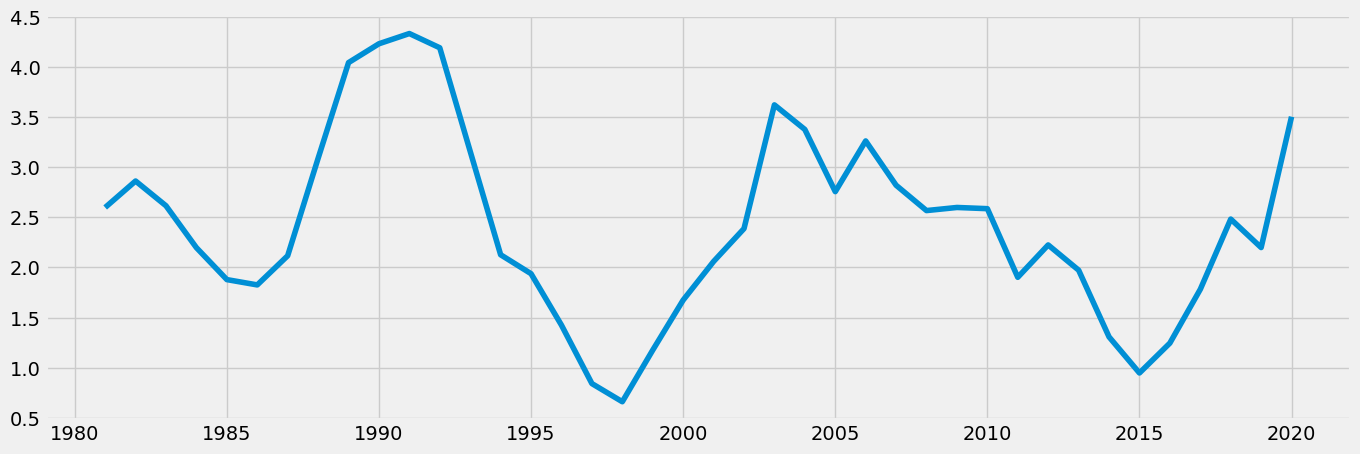

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.839794
p-value                         0.002525
Number of Lags Used             4.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


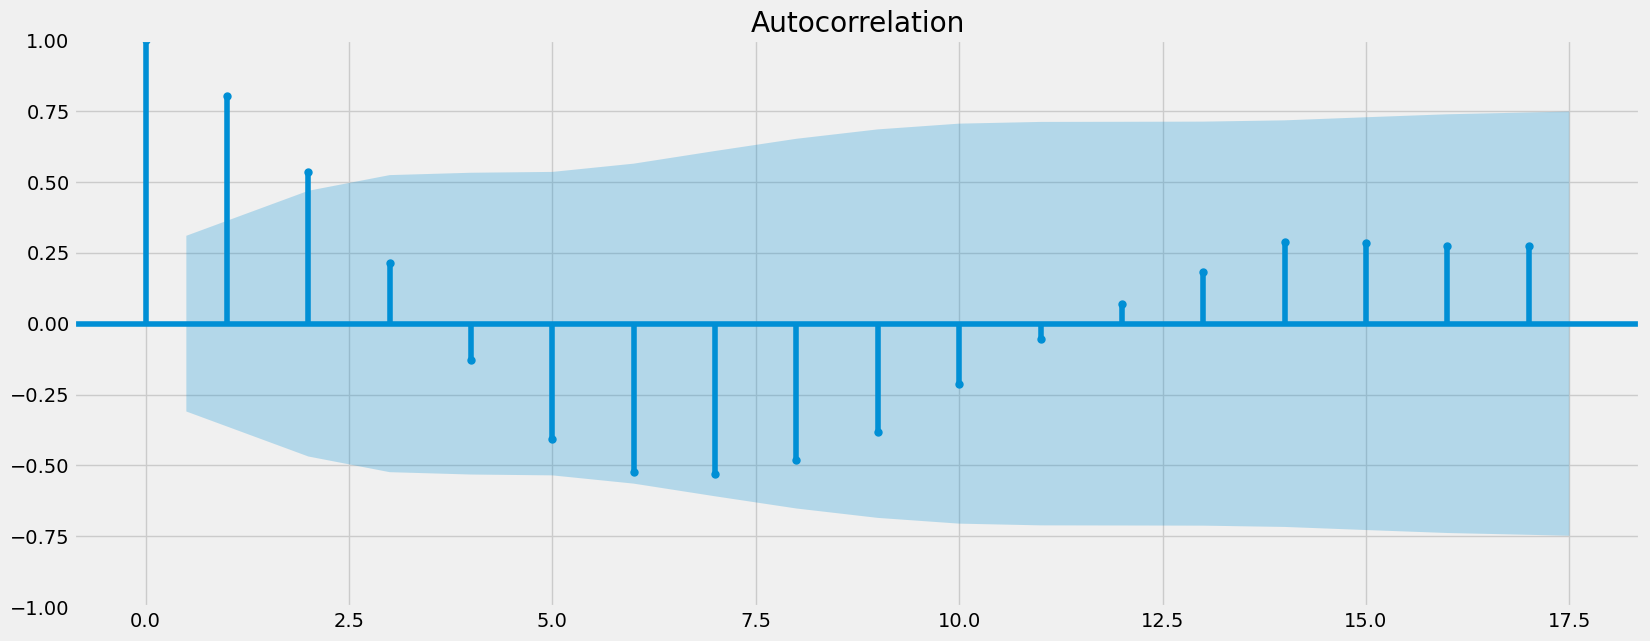

In [29]:
plot_acf(data_diff)
plt.show()

# Overall Findings:

There is not a lot of seasonality noted for this set although overall some hospitals do trend busier because this is by year you would not notice that and in the seasonal trend it was pretty much flat across the years. The Residual is also pretty straight forward  there is not a lot of fluctuation. 

The trend decomposition trends up over the years.

For the first autocorrection most of them do trend in the blue area that respresents they are in the confidence interval. The first couple where outliers. The data is pretty stationary as there are not too many lags. (This data has a trend 


The test statistic in the Dickey Fuller Stationarity test is lower than the critical value at the 5 and 10 percent significance level.  Test Statistic -3.839794 Critical Value (5%) -2.948510   Critical Value (10%)-2.613017. This would lead me to think this is a stationary data set. There is only three lines above the confidence interval so it should be fine.

One thing to note is that originially i had made a smaller set and then it was unable to analyze so I went back and added more years. 